# Big Data Analytics Project

Data Mining, Text Mining and Big Data Analytics

Vorabbi Sara - 0001026226 - sara.vorabbi@gmail.com

In this notebook we explore the Covertype dataset from UC Irvine Machine Learning Repository. We proceed by exploring the dataset, preprocessing it and training three Machine Learning algorithm on it.

[Covertype Dataset](https://archive.ics.uci.edu/dataset/31/covertype)

In this project we see the application of the PySpark framework, the Python API for Apache Spark. We see what can be achieved throught it and the limitations of the models.

This project was implemented using a Colab Notebook.

## Import file in Colab

In [1]:
# Import from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy the db in the current working folder `./`

In [2]:
!cp "/content/drive/MyDrive/DB_BDA/covtype.data.gz" ./

## Import the dataset with PySpark

We install the PySpark package and we proceed to import all the modules and classes we need for the project.

In [3]:
!pip install pyspark

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.sql.functions import col, sum as _sum, when

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

We create a Spark session configuring some parameters in order to control the behaviour reguarding resourses allocation and to improve the performance.

```
spark.driver.memory", "8g"
spark.executor.memory", "8g"
spark.executor.instances", "4"
spark.executor.cores", "2"
spark.sql.shuffle.partitions", "300"

SISTEMA LA CONFIGURATION DOCUMENTATION
https://spark.apache.org/docs/latest/configuration.html
```

Whithout these settings the training of the ML algorithms could not end because of an OOM error. Using this configurations the training managed to finish successfully

In [5]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("BDA_Project") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()

In [6]:
file_path = "/content/covtype.data.gz"

The dataset does not contain a header, so it is best to add a schema to the dataframe with `StructType` using the information from the documentation of the Covertype dataset.



In [7]:
# Create schema
schema = StructType([
    StructField("Elevation", IntegerType(), True),
    StructField("Aspect", IntegerType(), True),
    StructField("Slope", IntegerType(), True),
    StructField("Horizontal_Distance_To_Hydrology", IntegerType(), True),
    StructField("Vertical_Distance_To_Hydrology", IntegerType(), True),
    StructField("Horizontal_Distance_To_Roadways", IntegerType(), True),
    StructField("Hillshade_9am", IntegerType(), True),
    StructField("Hillshade_Noon", IntegerType(), True),
    StructField("Hillshade_3pm", IntegerType(), True),
    StructField("Horizontal_Distance_To_Fire_Points", IntegerType(), True),
    StructField("Wilderness_Area1", IntegerType(), True),
    StructField("Wilderness_Area2", IntegerType(), True),
    StructField("Wilderness_Area3", IntegerType(), True),
    StructField("Wilderness_Area4", IntegerType(), True),
    StructField("Soil_Type1", IntegerType(), True),
    StructField("Soil_Type2", IntegerType(), True),
    StructField("Soil_Type3", IntegerType(), True),
    StructField("Soil_Type4", IntegerType(), True),
    StructField("Soil_Type5", IntegerType(), True),
    StructField("Soil_Type6", IntegerType(), True),
    StructField("Soil_Type7", IntegerType(), True),
    StructField("Soil_Type8", IntegerType(), True),
    StructField("Soil_Type9", IntegerType(), True),
    StructField("Soil_Type10", IntegerType(), True),
    StructField("Soil_Type11", IntegerType(), True),
    StructField("Soil_Type12", IntegerType(), True),
    StructField("Soil_Type13", IntegerType(), True),
    StructField("Soil_Type14", IntegerType(), True),
    StructField("Soil_Type15", IntegerType(), True),
    StructField("Soil_Type16", IntegerType(), True),
    StructField("Soil_Type17", IntegerType(), True),
    StructField("Soil_Type18", IntegerType(), True),
    StructField("Soil_Type19", IntegerType(), True),
    StructField("Soil_Type20", IntegerType(), True),
    StructField("Soil_Type21", IntegerType(), True),
    StructField("Soil_Type22", IntegerType(), True),
    StructField("Soil_Type23", IntegerType(), True),
    StructField("Soil_Type24", IntegerType(), True),
    StructField("Soil_Type25", IntegerType(), True),
    StructField("Soil_Type26", IntegerType(), True),
    StructField("Soil_Type27", IntegerType(), True),
    StructField("Soil_Type28", IntegerType(), True),
    StructField("Soil_Type29", IntegerType(), True),
    StructField("Soil_Type30", IntegerType(), True),
    StructField("Soil_Type31", IntegerType(), True),
    StructField("Soil_Type32", IntegerType(), True),
    StructField("Soil_Type33", IntegerType(), True),
    StructField("Soil_Type34", IntegerType(), True),
    StructField("Soil_Type35", IntegerType(), True),
    StructField("Soil_Type36", IntegerType(), True),
    StructField("Soil_Type37", IntegerType(), True),
    StructField("Soil_Type38", IntegerType(), True),
    StructField("Soil_Type39", IntegerType(), True),
    StructField("Soil_Type40", IntegerType(), True),
    StructField("Cover_Type", IntegerType(), True),
])


In [8]:
df = spark.read.csv(file_path, header=False, schema=schema)
df.show(10)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

In [9]:
df.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soil_Type7: integer

## Dataset exploration

In this section we want to have a general sense of what is contained in the dataset.

In [ ]:
num_rows = df.count()

num_columns = len(df.columns)

print(f"The DataFrame has {num_rows} rows and {num_columns} columns.")

The DataFrame has 581012 rows and 55 columns.


From the documentation we know that each observation (entry of the db) was collected in one of the 4 wilderness areas located in the Roosevelt National Forest of northern Colorado. The region are the following:
*   Rawah (area 1)
*   Neota (area 2)
*   Comanche Peak (area 3)
*   Cache la Poudre (area 4)

In [ ]:
df.groupBy("Wilderness_Area1").count().show()
df.groupBy("Wilderness_Area2").count().show()
df.groupBy("Wilderness_Area3").count().show()
df.groupBy("Wilderness_Area4").count().show()

+----------------+------+
|Wilderness_Area1| count|
+----------------+------+
|               1|260796|
|               0|320216|
+----------------+------+

+----------------+------+
|Wilderness_Area2| count|
+----------------+------+
|               1| 29884|
|               0|551128|
+----------------+------+

+----------------+------+
|Wilderness_Area3| count|
+----------------+------+
|               1|253364|
|               0|327648|
+----------------+------+

+----------------+------+
|Wilderness_Area4| count|
+----------------+------+
|               1| 36968|
|               0|544044|
+----------------+------+



In [ ]:
wilderness_area1_sum = df.groupBy("Wilderness_Area1").count().filter("Wilderness_Area1 = 1").select("count").collect()[0][0]
wilderness_area2_sum = df.groupBy("Wilderness_Area2").count().filter("Wilderness_Area2 = 1").select("count").collect()[0][0]
wilderness_area3_sum = df.groupBy("Wilderness_Area3").count().filter("Wilderness_Area3 = 1").select("count").collect()[0][0]
wilderness_area4_sum = df.groupBy("Wilderness_Area4").count().filter("Wilderness_Area4 = 1").select("count").collect()[0][0]

sum = wilderness_area1_sum + wilderness_area2_sum + wilderness_area3_sum + wilderness_area4_sum
sum

581012

We can see how each entry of the db correspond to one of the 4 wilderness area.

Vediamo come ogni entry del db corrisponda a una delle

We now check that the classification class `Cover_type` has no null entry, as specified in the documentation.

In [ ]:
df.filter(df.Cover_Type.isNull()).show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

In [ ]:
df.groupBy("Cover_Type").count().orderBy("Cover_Type").show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         1|211840|
|         2|283301|
|         3| 35754|
|         4|  2747|
|         5|  9493|
|         6| 17367|
|         7| 20510|
+----------+------+



From the documentation we know that in each Wilderness Area are present various type of Cover Type:

**Area 2** (Neota)

*  Type 1 - Spruce/Fir

**Area 1** (Rawah) - **Area 3** (Comanche Peak)
*  Type 2 - Lodgepole
*  Type 1 - Spruce/Fir
*  Type 5 - Aspen

**Area 4** (Cache la Poudre)

*  Type 3 - Ponderosa pine
*  Type 6 - Douglas-fir
*  Type 4 - Cottonwood/willow

Per ogni wilderness area, guardiamo quanti covertype abbiamo

In [ ]:
# List of wilderness area columns
wilderness_areas = ["Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4"]

# Loop through each wilderness area and display Cover_Type distribution where the value is 1
for area in wilderness_areas:
    print(f"Cover_Type distribution in {area} where the value is 1:")
    df.groupBy(area, "Cover_Type") \
        .count() \
        .filter(f"{area} = 1") \
        .orderBy(col("count").desc()) \
        .show()

Cover_Type distribution in Wilderness_Area1 where the value is 1:
+----------------+----------+------+
|Wilderness_Area1|Cover_Type| count|
+----------------+----------+------+
|               1|         2|146197|
|               1|         1|105717|
|               1|         7|  5101|
|               1|         5|  3781|
+----------------+----------+------+

Cover_Type distribution in Wilderness_Area2 where the value is 1:
+----------------+----------+-----+
|Wilderness_Area2|Cover_Type|count|
+----------------+----------+-----+
|               1|         1|18595|
|               1|         2| 8985|
|               1|         7| 2304|
+----------------+----------+-----+

Cover_Type distribution in Wilderness_Area3 where the value is 1:
+----------------+----------+------+
|Wilderness_Area3|Cover_Type| count|
+----------------+----------+------+
|               1|         2|125093|
|               1|         1| 87528|
|               1|         3| 14300|
|               1|         7| 

### Check for the soil

In [ ]:
soil_type_features = [col for col in df.columns if col.startswith("Soil_Type")]

df_soil_check = df.withColumn("Soil_Type_Sum", sum(col(c) for c in soil_type_features))

invalid_soil_rows = df_soil_check.filter(col("Soil_Type_Sum") != 1)

invalid_count = invalid_soil_rows.count()

In [ ]:
if invalid_count == 0:
    print("All rows have exactly one Soil_Type set to 1.")
else:
    print(f"There are {invalid_count} rows with invalid Soil_Type combinations.")
    invalid_soil_rows.show(truncate=False)

All rows have exactly one Soil_Type set to 1.


In [ ]:
# Count the occurrences of each Soil_Type
for i in range(1, 41):
    df.groupBy(f"Soil_Type{i}") \
    .count() \
    .filter(f"Soil_Type{i} = 1") \
    .show()

+----------+-----+
|Soil_Type1|count|
+----------+-----+
|         1| 3031|
+----------+-----+

+----------+-----+
|Soil_Type2|count|
+----------+-----+
|         1| 7525|
+----------+-----+

+----------+-----+
|Soil_Type3|count|
+----------+-----+
|         1| 4823|
+----------+-----+

+----------+-----+
|Soil_Type4|count|
+----------+-----+
|         1|12396|
+----------+-----+

+----------+-----+
|Soil_Type5|count|
+----------+-----+
|         1| 1597|
+----------+-----+

+----------+-----+
|Soil_Type6|count|
+----------+-----+
|         1| 6575|
+----------+-----+

+----------+-----+
|Soil_Type7|count|
+----------+-----+
|         1|  105|
+----------+-----+

+----------+-----+
|Soil_Type8|count|
+----------+-----+
|         1|  179|
+----------+-----+

+----------+-----+
|Soil_Type9|count|
+----------+-----+
|         1| 1147|
+----------+-----+

+-----------+-----+
|Soil_Type10|count|
+-----------+-----+
|          1|32634|
+-----------+-----+

+-----------+-----+
|Soil_Type11|co

## Pre processing

As seen in the Dataset Exploration section the dataset values have different scales and units of measurement. Many ML algorithms are sensitive to magnitude changes, so we want to scale the features in order to be able to increase the performance at training time and the convergence of the model.

In [10]:
input_columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                 "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                 "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]

In [11]:
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [12]:
df_assembled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area

We change the classification class in such way that the classes start from 0.

In [13]:
df_assembled = df_assembled.withColumn("Cover_Type", df["Cover_Type"] - 1)
df_assembled.groupBy("Cover_Type").count().orderBy("Cover_Type").show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         0|211840|
|         1|283301|
|         2| 35754|
|         3|  2747|
|         4|  9493|
|         5| 17367|
|         6| 20510|
+----------+------+



### Min Max Scaler

In [14]:
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
minmax_model = minmax_scaler.fit(df_assembled)

In [15]:
df_mm_scaled = minmax_model.transform(df_assembled)
df_mm_scaled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_

We can see that the values range from 0 to 1.

In [16]:
df_mm_scaled.select("scaled_features").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.36868434217108553,0.14166666666666666,0.045454545454545456,0.18468146027201143,0.2235142118863049,0.07165940705353378,0.8700787401574803,0.9133858267716535,0.5826771653543307,0.875365955667085]  |
|[0.36568284142071034,0.15555555555555556,0.030303030303030304,0.15175375805297064,0.2157622739018088,0.054798370099761136,0.8661417322834646,0.9251968503937008,0.5944881889763779,0.86783772480133

Now we assemble the scaled features with the 40 one hot encoded Soil Type features with Vector Assembler

In [17]:
soil_type_cols = [col for col in df.columns if col.startswith("Soil_Type")]

final_assembler = VectorAssembler(
    inputCols=["scaled_features"] + soil_type_cols,  #add soil_type col to the scaled_features
    outputCol="final_features"
)

df_mm_final = final_assembler.transform(df_mm_scaled)

In [18]:
df_mm_final.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fi

In [19]:
df_mm_final.select("final_features").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(50,[0,1,2,3,4,5,6,7,8,9,38],[0.36868434217108553,0.14166666666666666,0.045454545454545456,0.18468146027201143,0.2235142118863049,0.07165940705353378,0.8700787401574803,0.9133858267716535,0.5826771653543307,0.875365955667085,1.0])  |
|(50,[0,1,2,3,4,5,6,7,8,9,38],[0.36568284142071034,0.1555555

### Standard Scaler

In [20]:
standardScaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
std_model = standardScaler.fit(df_assembled)

In [21]:
df_std_scaled = std_model.transform(df_assembled)
df_std_scaled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_

In [22]:
df_std_scaled.select("scaled_features").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.2978039731955449,-0.9351561765108982,-1.4828185057396976,-0.053767354866423554,-0.796271909057315,-1.1801448544140933,0.3307429270918281,0.43914293510260455,0.14296027552922155,3.2462802628404894]|
|[-1.3192337129849612,-0.8904789023109558,-1.6163612017122402,-0.2701876769662561,-0.8991962792425542,-1.2571046910108385,0.2933875235160505,0.5908980040725195,0.22134138328529157,3.205500

In [23]:
soil_type_cols = [col for col in df.columns if col.startswith("Soil_Type")]

In [24]:
final_assembler = VectorAssembler(
    inputCols=["scaled_features"] + soil_type_cols,  #add soil_type col to the scaled_features
    outputCol="final_features"
)

df_std_final = final_assembler.transform(df_std_scaled)

In [25]:
df_std_final.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fi

In [26]:
df_std_final.select('final_features').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(50,[0,1,2,3,4,5,6,7,8,9,38],[-1.2978039731955449,-0.9351561765108982,-1.4828185057396976,-0.053767354866423554,-0.796271909057315,-1.1801448544140933,0.3307429270918281,0.43914293510260455,0.14296027552922155,3.2462802628404894,1.0])|
|(50,[0,1,2,3,4,5,6,7,8,9,38],[-1.3192337129849612,-

## Histogramps

Ora cerchiamo di fare gli istogrammi per le feauture per capire la distribuzione dei dati

In [ ]:
# Import required libraries for plotting
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Select columns to analyze
columns_to_analyze = ['Elevation_scaled', 'Aspect_scaled', 'Slope_scaled', 'Horizontal_Distance_To_Hydrology_scaled',
                      'Vertical_Distance_To_Hydrology_scaled', 'Horizontal_Distance_To_Roadways_scaled',
                      'Hillshade_9am_scaled', 'Hillshade_Noon_scaled', 'Hillshade_3pm_scaled',
                      'Horizontal_Distance_To_Fire_Points_scaled']

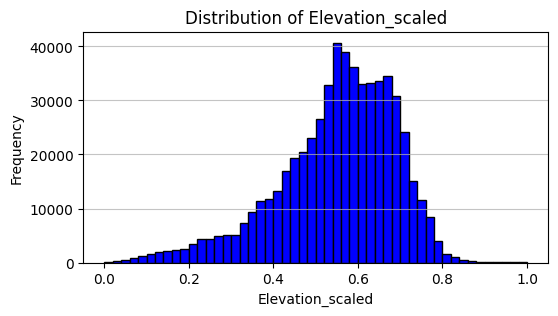

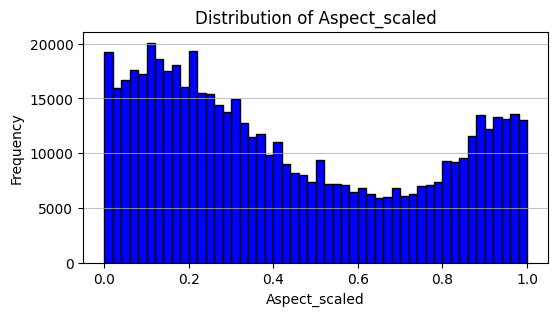

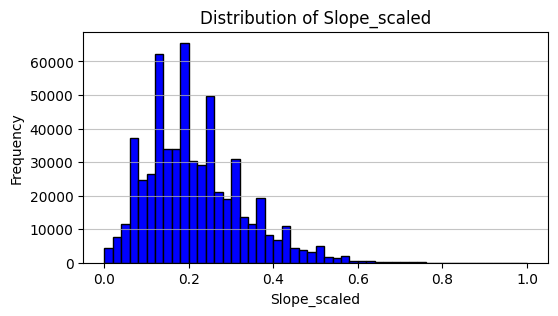

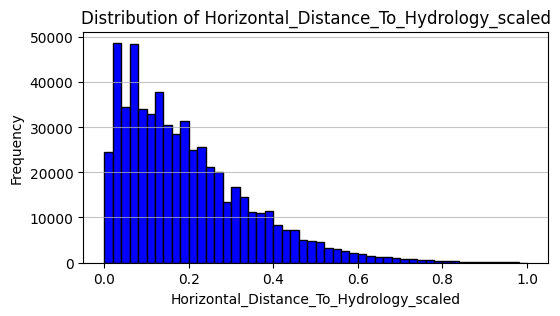

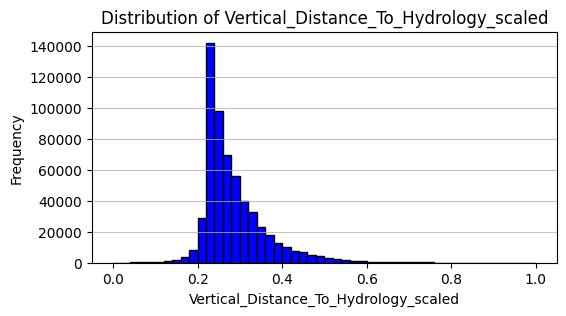

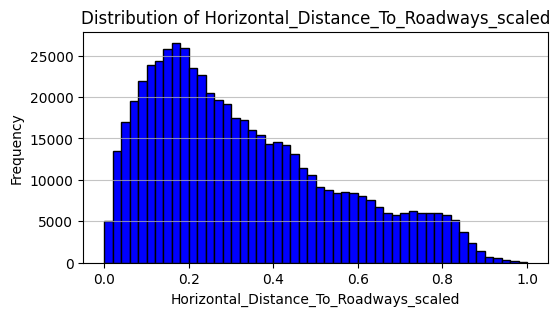

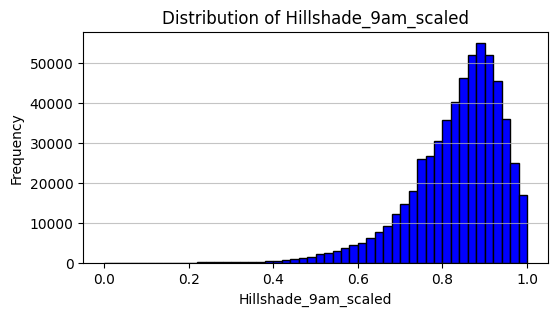

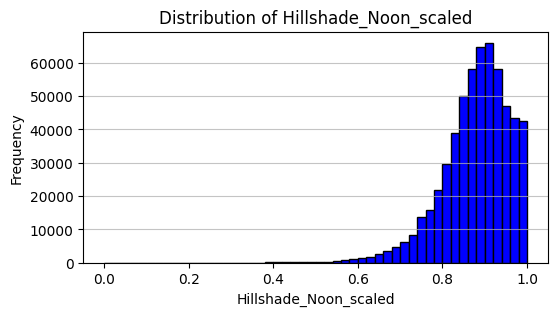

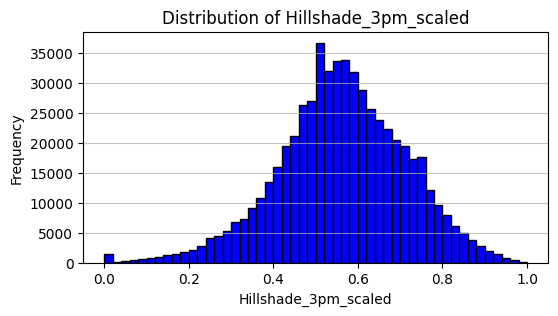

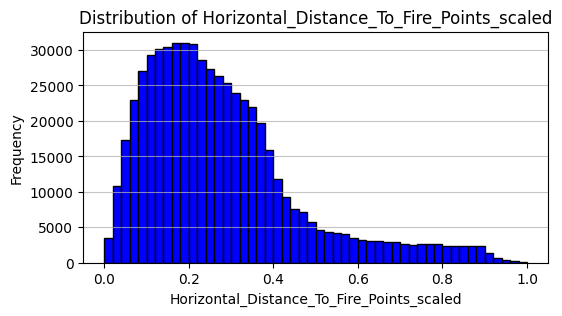

In [ ]:
# # Loop through each column and collect data for histogram plotting
# for col in columns_to_analyze:
#     # Collect column data as a Pandas Series
#     column_data = df_new.select(col).rdd.flatMap(lambda x: x).collect()

#     # Plot the histogram using Matplotlib
#     plt.figure(figsize=(6, 3))  # Smaller size
#     plt.hist(column_data, bins=50, color='blue', edgecolor='black')
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Occurrency')
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()



Analizziamo anche le feature prima di essere scalate per vedere se tutto combacia

In [ ]:
# Select columns to analyze
columns_to_analyze_not_scaled = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                      'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                      'Horizontal_Distance_To_Fire_Points']

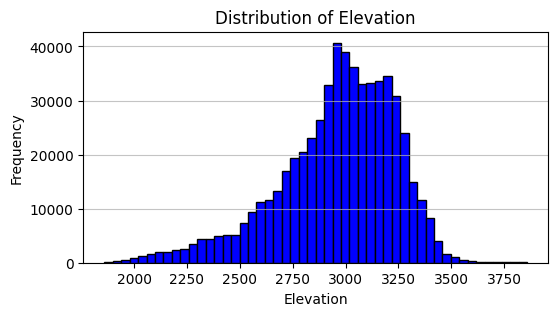

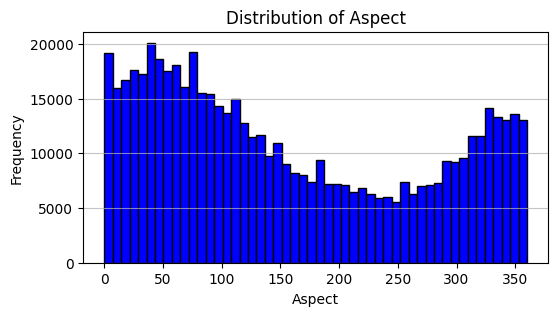

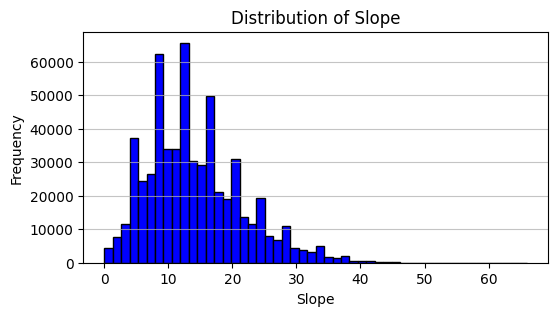

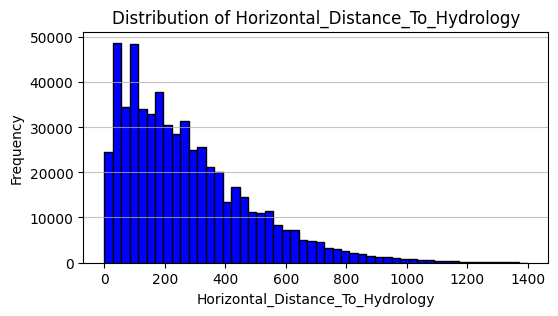

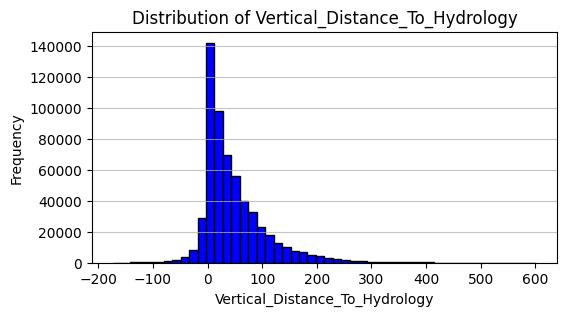

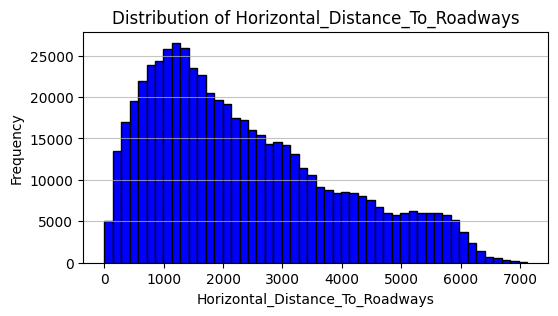

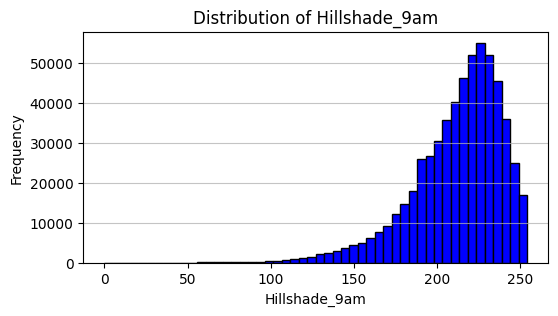

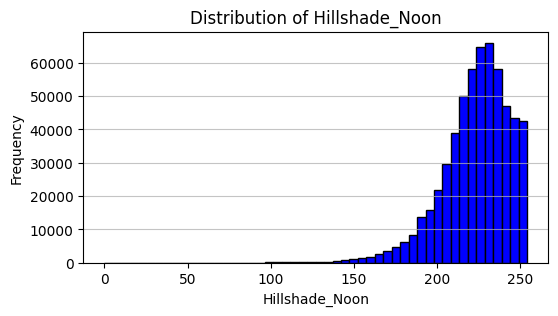

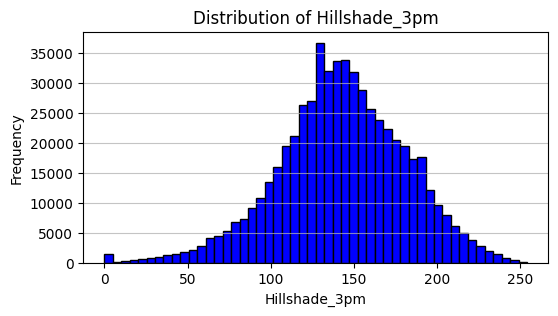

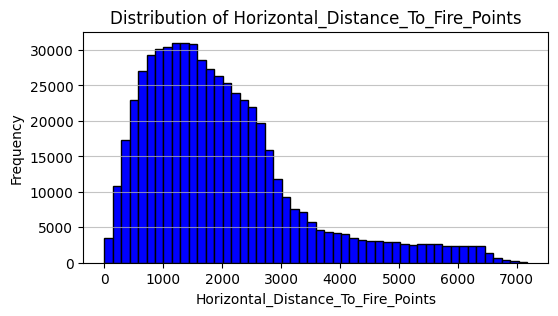

In [ ]:
# # Loop through each column and collect data for histogram plotting
# for col in columns_to_analyze_not_scaled:
#     # Collect column data as a Pandas Series
#     column_data = df.select(col).rdd.flatMap(lambda x: x).collect()

#     # Plot the histogram using Matplotlib
#     plt.figure(figsize=(6, 3))  # Smaller size
ax, fig = plt.figure((1, 2), figsize=(6,3))
ax[0].hist(column_data)
ax[1]

#     plt.hist(column_data, bins=50, color='blue', edgecolor='black')
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Occurrency')
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()


Bisogna controllare quei parametri belli tipo Recall etc... tipo

## Evaluation

MulticlassCLassificationEvaluator
- Accuracy
- F1 Score
- Precision and Recall

Things you can put in `evaluator.setMetricName("accuracy")`

`(f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss)`

In [27]:
# define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Cover_Type", predictionCol="prediction")

In [28]:
def compute_metrics(predictions):
    evaluator.setMetricName("accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Test Accuracy = {accuracy:.2f}")

    evaluator.setMetricName("f1")
    f1_score = evaluator.evaluate(predictions)
    print(f"F1 Score = {f1_score:.2f}")

    evaluator.setMetricName("weightedPrecision")
    weighted_precision = evaluator.evaluate(predictions)
    print(f"Weighted Precision = {weighted_precision:.2f}")

    evaluator.setMetricName("weightedRecall")
    weighted_recall = evaluator.evaluate(predictions)
    print(f"Weighted Recall = {weighted_recall:.2f}")


Random Forest evaluation

In [ ]:
compute_metrics(rfPred)

Test Accuracy = 0.71
F1 Score = 0.68
Weighted Precision = 0.68
Weighted Recall = 0.71


## Train and Test Set

We see how Spark uses a Sparse Representation to save mamory since we have a lot of binary features.

**Why Use Sparse Representation?**
Sparse representation is useful because many machine learning datasets have a significant number of binary features or other features that are often zero. Instead of storing all the zeros, the sparse vector format only stores the positions and values of the non-zero elements, saving memory. - from internet

Split the DataFrame in train set and test set

In [29]:
(trainSplit_mm, testSplit_mm) = df_mm_final.randomSplit([0.7, 0.3], seed=42)

In [30]:
(trainSplit_std, testSplit_std) = df_std_final.randomSplit([0.7, 0.3], seed=42)

In [ ]:
num_rows = trainSplit_mm.count()
num_columns = len(trainSplit_mm.columns)
print(f"The train split has {num_rows} rows and {num_columns} columns.")

num_rows = testSplit_mm.count()
num_columns = len(testSplit_mm.columns)
print(f"The test split has {num_rows} rows and {num_columns} columns.")

The train split has 406644 rows and 58 columns.
The test split has 174368 rows and 58 columns.


In [ ]:
print("Training Dataset Count: " + str(trainSplit_mm.count()))
print("Test Dataset Count: " + str(testSplit_mm.count()))

Training Dataset Count: 406644
Test Dataset Count: 174368


In [ ]:
# trainSplit.show(5)
# testSplit.show(5)

## Algorithms

In this project we can see the application of 3 Machine Learning **classification** algorithms. In particular:

*   Random Forest
*   Naive Bayes
*   Logistic Regression


*   k-nearest neighbours(KNN)
*   decision tree????


### Naive Bayes

In [ ]:
nb = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="final_features", \
                modelType="multinomial", \
                smoothing=1.0)

In [ ]:
# fit and evaluate the model
nbModel = nb.fit(trainSplit_mm)
nbPred = nbModel.transform(testSplit_mm)

In [ ]:
compute_metrics(nbPred) # smoothing=1

Test Accuracy = 0.21
F1 Score = 0.18
Weighted Precision = 0.21
Weighted Recall = 0.21


The Naive Bayes method does not return great results, being just a bit better than a random classifier. This could be due to the fact that the dataset is highly imbalanced as seen in the Dataset Exploration section. By showing the predictions of the model we see that the fist 2 classes, the most numerous, are also those that contain the most predictions.

In [ ]:
nbPred.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+------+
|prediction| count|
+----------+------+
|       1.0|108125|
|       0.0| 47143|
|       2.0| 18429|
|       6.0|   362|
|       5.0|   306|
|       3.0|     3|
+----------+------+



A further analysis might be conducted by balancing the dataset, either undersampling the most numerous classes, either assigning weights to the classes (in particular high weights to the minority classes in order to counteract the imbalance).

In [ ]:
total_samples = trainSplit_mm.count()
total_samples

406644

#### Weigthing col

In [ ]:
# check il calcolo per creare il weight
class_counts_df = trainSplit_mm.groupBy("Cover_Type").count()

class_counts = class_counts_df.collect()

class_weights = {row['Cover_Type']: total_samples / row['count'] for row in class_counts}

In [ ]:
trainSplit_weights = trainSplit_mm.withColumn("weight",
                                    when(trainSplit_mm.Cover_Type == 1, class_weights[1])
                                   .when(trainSplit_mm.Cover_Type == 2, class_weights[2])
                                   .when(trainSplit_mm.Cover_Type == 3, class_weights[3])
                                   .when(trainSplit_mm.Cover_Type == 4, class_weights[4])
                                   .when(trainSplit_mm.Cover_Type == 5, class_weights[5])
                                   .when(trainSplit_mm.Cover_Type == 6, class_weights[6])
                                   .when(trainSplit_mm.Cover_Type == 7, class_weights[7])
                                )

In [ ]:
nb_weight = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="final_features", \
                modelType="multinomial", \
                smoothing=1.0, \
                weightCol="weight")

In [ ]:
nbModel_weight = nb_weight.fit(trainSplit_weights)
nbPred_weight = nbModel_weight.transform(testSplit_mm)

In [ ]:
compute_metrics(nbPred_weight)

Test Accuracy = 0.16
F1 Score = 0.16
Weighted Precision = 0.25
Weighted Recall = 0.16


### Random Forest

In [ ]:
# define rf model
rf_2 = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="final_features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
rfModel_2 = rf_2.fit(trainSplit_mm)
rfPred_2 = rfModel_2.transform(testSplit_mm)

In [ ]:
compute_metrics(rfPred_2)

Test Accuracy = 0.70
F1 Score = 0.67
Weighted Precision = 0.69
Weighted Recall = 0.70


In [ ]:
# define rf model
rf_3 = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="scaled_features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
rfModel_3 = rf_3.fit(trainSplit_std)

In [ ]:
rfPred_3 = rfModel_3.transform(testSplit_std)

In [ ]:
compute_metrics(rfPred_3)

Test Accuracy = 0.70
F1 Score = 0.67
Weighted Precision = 0.69
Weighted Recall = 0.70


In [ ]:
rf_spark = RandomForestClassifier(labelCol="Cover_Type", \
                                  featuresCol="final_features", \
                                  numTrees=100,
                                  maxDepth=30,
                                  minInstancesPerNode=2,
                                  featureSubsetStrategy="sqrt",
                                  seed=42)

In [ ]:
# fit and evaluate the model
rfModel = rf_spark.fit(trainSplit_mm)
rfPred = rfModel.transform(testSplit_mm)

In [ ]:
compute_metrics(rfPred)

Test Accuracy = 0.89
F1 Score = 0.88
Weighted Precision = 0.89
Weighted Recall = 0.89


In [ ]:
rfPred.select("Cover_Type", "prediction", "features").show()

In [ ]:
rfModel.featureImportances

### Logistic regression

Better performance having:
-  a lower `regParam`
- `standardization` set to True


In [ ]:
lr = LogisticRegression(featuresCol="final_features",
                        labelCol="Cover_Type",
                        maxIter=500,
                        regParam=0.00,
                        elasticNetParam=0.8,
                        tol=1e-10,
                        standardization=True)

In [ ]:
lrModel = lr.fit(trainSplit_mm)
lrPred = lrModel.transform(testSplit_mm)

In [ ]:
compute_metrics(lrPred)

Test Accuracy = 0.72
F1 Score = 0.70
Weighted Precision = 0.70
Weighted Recall = 0.72


In [ ]:
compute_metrics(lrPred)# lr = LogisticRegression(featuresCol="final_features",
                                                    # labelCol="Cover_Type",
                                                    # maxIter=500,
                                                    # regParam=0.00,
                                                    # elasticNetParam=1.0, <======== cambiato questo
                                                    # standardization=True)

Test Accuracy = 0.72
F1 Score = 0.70
Weighted Precision = 0.70
Weighted Recall = 0.72


In [ ]:
compute_metrics(lrPred)     # lr = LogisticRegression(featuresCol="final_features",
                                                            # labelCol="Cover_Type",
                                                            # maxIter=500,
                                                            # regParam=0.00, <======== cambiato questo
                                                            # elasticNetParam=0.0,
                                                            # standardization=True)

Test Accuracy = 0.72
F1 Score = 0.70
Weighted Precision = 0.70
Weighted Recall = 0.72


In [ ]:
compute_metrics(lrPred) # lr = LogisticRegression(featuresCol="final_features",
                                                # labelCol="Cover_Type",
                                                # maxIter=500,
                                                # regParam=0.01,  <======== cambiato questo
                                                # elasticNetParam=0.0,
                                                # standardization=True)

Test Accuracy = 0.70
F1 Score = 0.68
Weighted Precision = 0.68
Weighted Recall = 0.70


In [ ]:
# QUESTO ANCHE DA ELIMINARE, BASTA CHE TI RICORDI CHE TI è SERVITO PER AVERE regParam=0.8 CHE NON FUNZIA (tropo alto)

compute_metrics(lrPred)     # lr = LogisticRegression(featuresCol="final_features",
                                # labelCol="Cover_Type",
                                # maxIter=500,
                                # regParam=0.8, <======== cambiato questo
                                # elasticNetParam=0.0,
                                # standardization=True)

Test Accuracy = 0.60
F1 Score = 0.54
Weighted Precision = 0.59
Weighted Recall = 0.60


In [ ]:
compute_metrics(lrPred)     #lr = LogisticRegression(featuresCol="final_features",
                                    # labelCol="Cover_Type",
                                    # maxIter=500,
                                    # regParam=0.1,
                                    # elasticNetParam=0.0,
                                    # standardization=True) <======== cambiato questo

Test Accuracy = 0.68
F1 Score = 0.64
Weighted Precision = 0.67
Weighted Recall = 0.68


In [ ]:
compute_metrics(lrPred) # lr = LogisticRegression(featuresCol="final_features",
                                                    # labelCol="Cover_Type",
                                                    # maxIter=500,
                                                    # regParam=0.1,
                                                    # elasticNetParam=0.0,
                                                    # standardization=False)

Test Accuracy = 0.55
F1 Score = 0.45
Weighted Precision = 0.54
Weighted Recall = 0.55


#### DA ELIMINARE - CROSS VALIDATION PER TROVARE I PARAM MIGLIORI

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
train_lr = trainSplit_lr.withColumnRenamed("Cover_Type", "label")
trest_lr = testSplit_lr.withColumnRenamed("Cover_Type", "label")

list_to_drop = ["features", "scaled_features"]

train_lr = train_lr.drop(*list_to_drop)
trest_lr = trest_lr.drop(*list_to_drop)

# train_lr = train_lr.drop(train_lr.scaled_features)
# trest_lr = trest_lr.drop(trest_lr.scaled_features)

train_lr = train_lr.withColumnRenamed("final_features", "features")
trest_lr = trest_lr.withColumnRenamed("final_features", "features")

In [ ]:
train_lr.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wil

In [ ]:
lr_cross = LogisticRegression(featuresCol="features",
                        labelCol="label",
                        maxIter=500,
                        regParam=0.00,
                        elasticNetParam=0.8,
                        tol=1e-10,
                        standardization=True)

### PCA

In [31]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=2, inputCol="final_features")
pca.setOutputCol("pca_features")

In [ ]:
model = pca.fit(df_mm_final)

### Clustering

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans(featuresCol="final_features", k=7, seed=42)  # Start with k=7
kmeans_model = kmeans.fit(df_mm_final)
clustered_df = kmeans_model.transform(df_mm_final)

In [ ]:
clustered_df.groupBy("prediction").count().orderBy(col("prediction")).show()
clustered_df.groupBy("Cover_Type").count().orderBy(col("Cover_Type")).show()

+----------+------+
|prediction| count|
+----------+------+
|         0| 97673|
|         1| 87922|
|         2| 29971|
|         3| 85432|
|         4|115247|
|         5|117823|
|         6| 46944|
+----------+------+

+----------+------+
|Cover_Type| count|
+----------+------+
|         1|211840|
|         2|283301|
|         3| 35754|
|         4|  2747|
|         5|  9493|
|         6| 17367|
|         7| 20510|
+----------+------+



In [ ]:
cluster_class_mapping = clustered_df.groupBy("prediction", "Cover_Type").count()

In [ ]:
cluster_class_mapping.orderBy("prediction", "Cover_Type").show()

+----------+----------+-----+
|prediction|Cover_Type|count|
+----------+----------+-----+
|         0|         1|39506|
|         0|         2|54864|
|         0|         3|  111|
|         0|         5|  978|
|         0|         6|  739|
|         0|         7| 1475|
|         1|         1|43201|
|         1|         2|40979|
|         1|         5| 2810|
|         1|         6|   29|
|         1|         7|  903|
|         2|         1| 2693|
|         2|         2|27278|
|         3|         1|53289|
|         3|         2|15431|
|         3|         5|   16|
|         3|         7|16696|
|         4|         1|41911|
|         4|         2|71399|
|         4|         5| 1132|
+----------+----------+-----+
only showing top 20 rows



In [ ]:
pivot_table = cluster_class_mapping.groupBy("prediction") \
                                   .pivot("Cover_Type") \
                                   .sum("count")

pivot_table = pivot_table.fillna(0)

pivot_table.show()

+----------+-----+-----+-----+----+----+-----+-----+
|prediction|    1|    2|    3|   4|   5|    6|    7|
+----------+-----+-----+-----+----+----+-----+-----+
|         1|43201|40979|    0|   0|2810|   29|  903|
|         6|23027|22911|    0|   0| 379|  201|  426|
|         3|53289|15431|    0|   0|  16|    0|16696|
|         5| 8213|50439|35643|2747|4178|16398|  205|
|         4|41911|71399|    0|   0|1132|    0|  805|
|         2| 2693|27278|    0|   0|   0|    0|    0|
|         0|39506|54864|  111|   0| 978|  739| 1475|
+----------+-----+-----+-----+----+----+-----+-----+



## ML Algorithms OLD!!!

### A2. df_scaled

In [ ]:
(trainSplit, testSplit) = df_mm_scaled.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# define rf model
rf = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="scaled_features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
# fit and evaluate the model
rfModel = rf.fit(trainSplit)
rfPred = rfModel.transform(testSplit)

In [ ]:
compute_metrics(rfPred)

Test Accuracy = 0.73
F1 Score = 0.71
Weighted Precision = 0.74
Weighted Recall = 0.73


### B. Naive Bayes

In [ ]:
nb = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="scaled_features", \
                modelType="multinomial", \
                smoothing=0.5)
                # smoothing=1.0, \
                # modelType="multinomial", \
                # weightCol="weight")

In [ ]:
# fit and evaluate the model
nbModel = nb.fit(trainSplit)
nbPred = nbModel.transform(testSplit)

In [ ]:
# metric with modelType="multinomial" - smoothing=0.5
compute_metrics(nbPred)

Test Accuracy = 0.36
F1 Score = 0.19
Weighted Precision = 0.13
Weighted Recall = 0.36


In [ ]:
# metric with modelType="multinomial" + smoothing=0.3
compute_metrics(nbPred)

Test Accuracy = 0.36
F1 Score = 0.19
Weighted Precision = 0.13
Weighted Recall = 0.36


In [ ]:
# metric with modelType="multinomial" + smoothing=0.8
compute_metrics(nbPred)

Test Accuracy = 0.36
F1 Score = 0.19
Weighted Precision = 0.13
Weighted Recall = 0.36


In [ ]:
nbPred.select("Cover_Type", "prediction", "features").show(5)

+----------+----------+--------------------+
|Cover_Type|prediction|            features|
+----------+----------+--------------------+
|         3|       2.0|(54,[0,1,2,3,4,5,...|
|         3|       2.0|(54,[0,1,2,3,4,5,...|
|         6|       2.0|(54,[0,1,2,3,4,5,...|
|         6|       2.0|(54,[0,1,2,3,4,5,...|
|         6|       2.0|(54,[0,1,2,3,4,5,...|
+----------+----------+--------------------+
only showing top 5 rows



## Prove con db non normalizzato

In [ ]:
feature_columns_N = ['Elevation',
                     'Aspect',
                     'Slope',
                     'Horizontal_Distance_To_Hydrology',
                     'Vertical_Distance_To_Hydrology',
                     'Horizontal_Distance_To_Roadways',
                     'Hillshade_9am',
                     'Hillshade_Noon',
                     'Hillshade_3pm',
                     'Horizontal_Distance_To_Fire_Points',
                     'Wilderness_Area1',
                     'Wilderness_Area2',
                     'Wilderness_Area3',
                     'Wilderness_Area4',
                     'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
                     'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
                     'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
                     'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
                     'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25',
                     'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
                     'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
                     'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
                     ]

In [ ]:
# Use VectorAssembler to combine feature columns into a single "features" column
assembler_N = VectorAssembler(inputCols=feature_columns_N, outputCol="features")

df_assembled_N = assembler_N.transform(df)


In [ ]:
df_assembled_N.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area

In [ ]:
(trainSplit_N, testSplit_N) = df_assembled_N.randomSplit([0.7, 0.3], seed=42)

Random forest

In [ ]:
# define rf model
rf_N = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
rf_N = RandomForestClassifier(labelCol="Cover_Type", \
                                  featuresCol="features", \
                                  numTrees=100,
                                  maxDepth=30,
                                  minInstancesPerNode=2,
                                  featureSubsetStrategy="sqrt",
                                  seed=42)

In [ ]:
# fit and evaluate the model
rfModel_N = rf_N.fit(trainSplit_N)
rfPred_N = rfModel_N.transform(testSplit_N)

In [ ]:
compute_metrics(rfPred_N)

Test Accuracy = 0.88
F1 Score = 0.88
Weighted Precision = 0.88
Weighted Recall = 0.88
